In [1]:
!pip install -q segmentation-models-pytorch

from glob import glob
import os
import time

import albumentations as A
import cv2
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.morphology import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Loading data

In [3]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [4]:
get_file_row('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif')

['TCGA_DU_7010',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif']

In [5]:
files_dir = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

I am not sure if the csv data would be useful, but I'll put it together with the images anyway.

In [6]:
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [7]:
imputer = SimpleImputer(strategy="most_frequent")
print(list(df.columns))
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster', 'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster', 'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site', 'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic', 'race', 'ethnicity', 'death01']


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,2.0,5.0,2,1.0,2.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,2.0,5.0,2,1.0,2.0,2.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [8]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
1,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
2,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
4,TCGA_DU_7010,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
...,...,...,...
3924,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3925,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3926,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3927,TCGA_DU_7306,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...


In [9]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [10]:
df = pd.merge(df, filenames_df, on="Patient")

# 2. Preparing the datasets

In [11]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, valid_df = train_test_split(test_df, test_size=0.5)

Only applied channel dropout and random color changes, the model gave subpar results when confronted with rotations and flips.

In [12]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

In [13]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# 3. Visualization and analysis

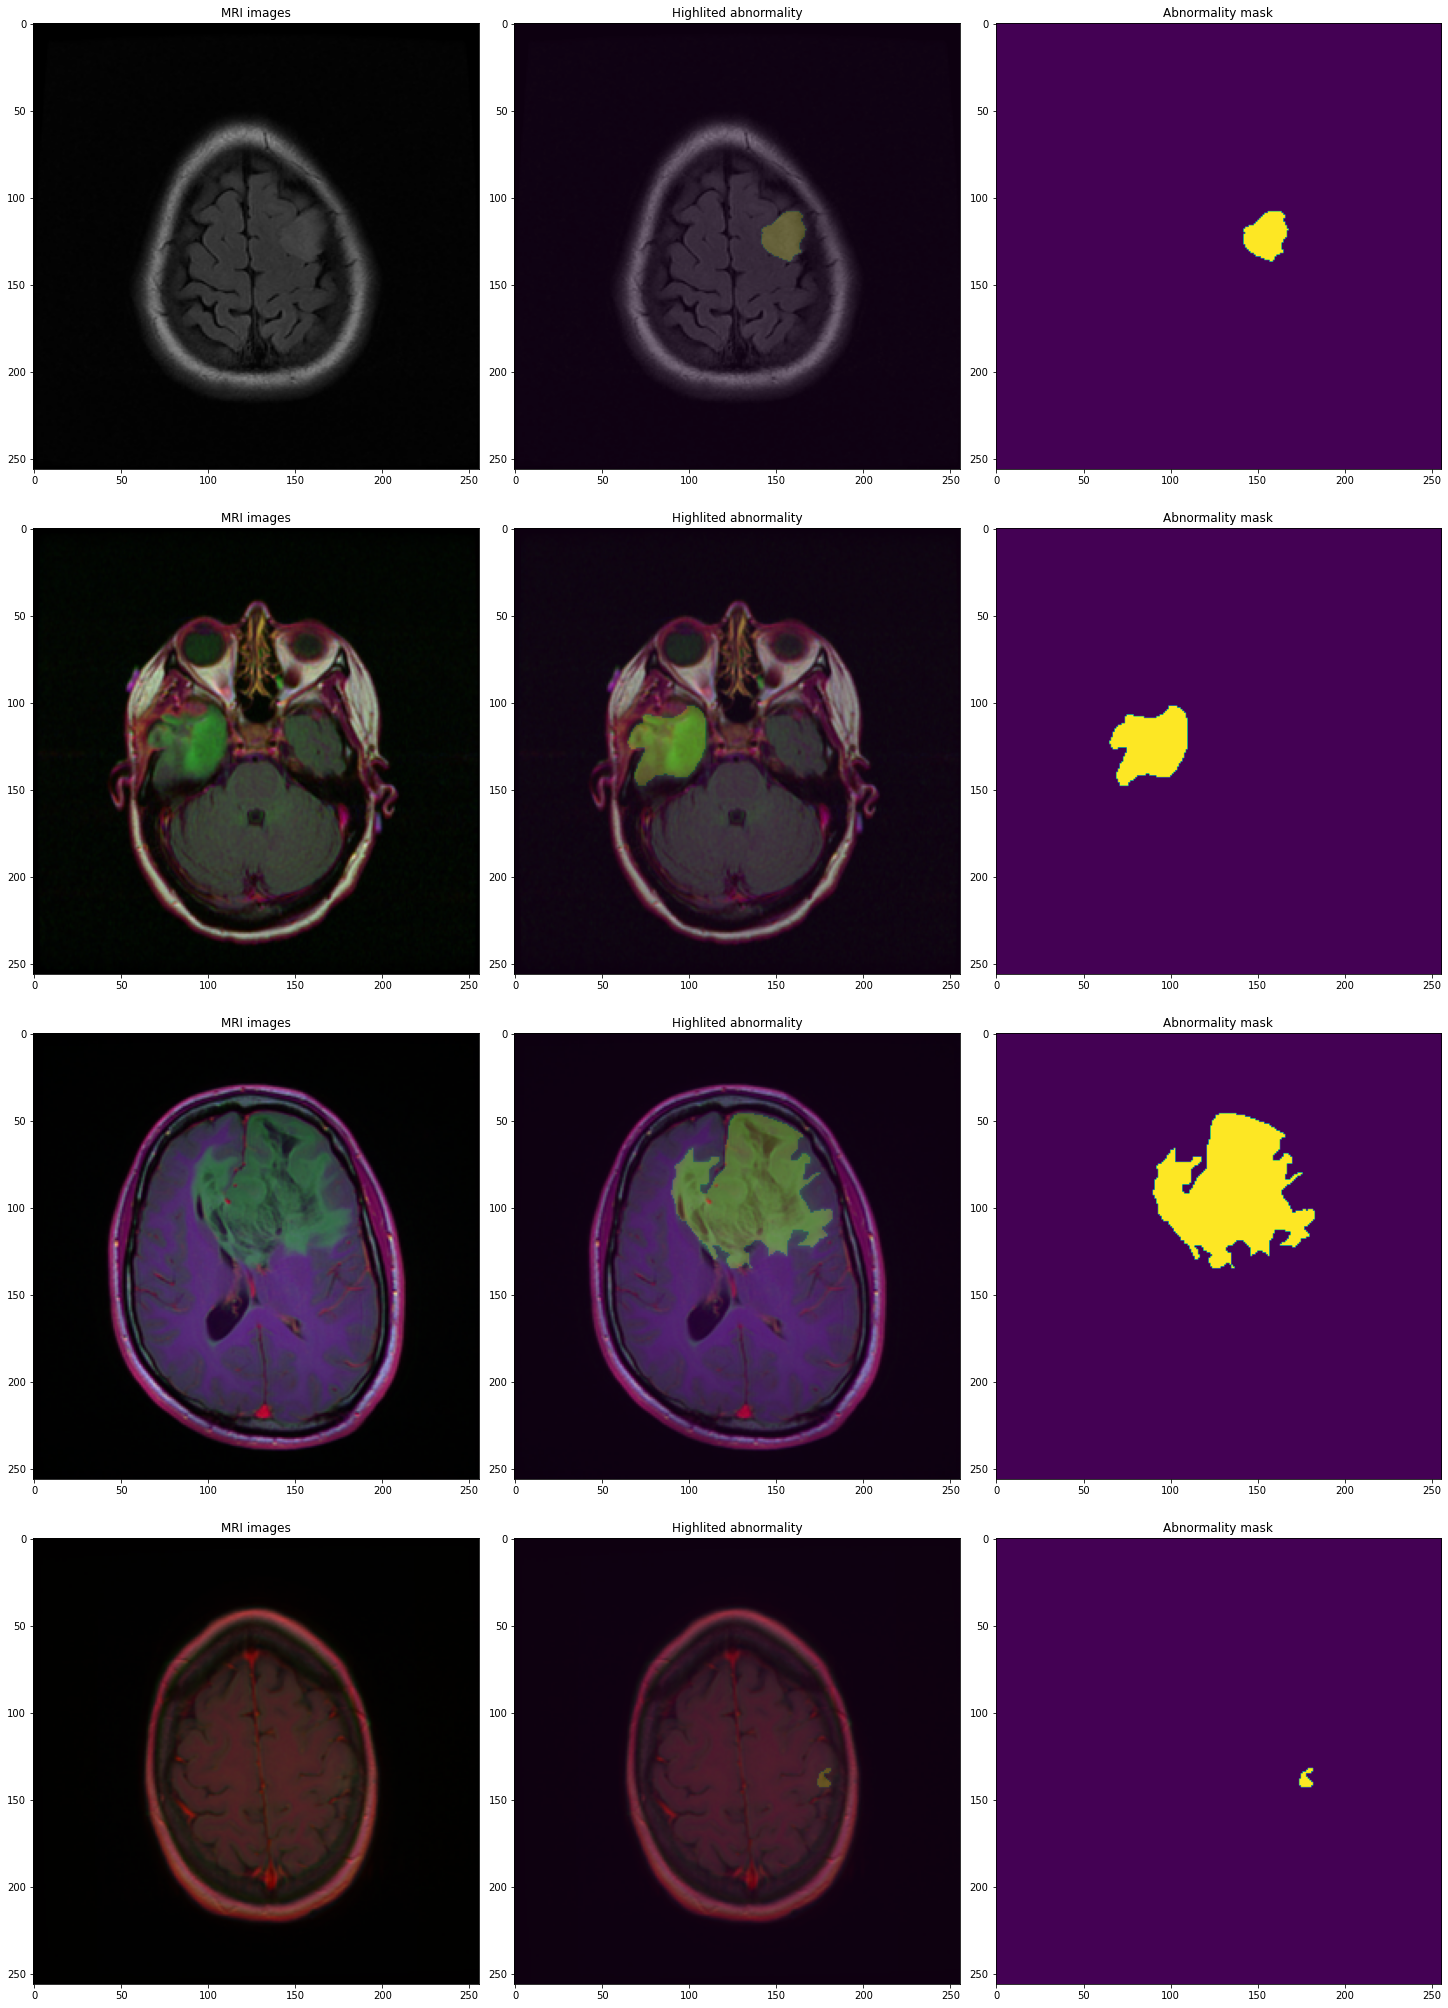

In [14]:
%matplotlib inline
n_examples = 4

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break
        
    
    

# 4. Preparing model and training

In [15]:
class EarlyStopping():
    """
    Stops training when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        """
        :param patience: number of epochs of non-decreasing loss before stopping
        :param min_delta: minimum difference between best and new loss that is considered
            an improvement
        :paran weights_path: Path to the file that should store the model's weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        """
        Loads weights of the best model.
        :param model: model to which the weigths should be loaded
        """
        return model.load_state_dict(torch.load(self.weights_path))
            

In [16]:
def iou_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Intersection over Union for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    
    intersection = (predictions & labels).float().sum((1, 2))
    union = (predictions | labels).float().sum((1, 2))
    
    iou = (intersection + e) / (union + e)
    return iou

def dice_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Dice coefficient for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    
    intersection = (predictions & labels).float().sum((1, 2))
    return ((2 * intersection) + e) / (predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e)

Adding custom lose consisting of binary crossentropy and soft dice coefficient gives slightly better results.

In [17]:
def BCE_dice(output, target, alpha=0.01):
    bce = torch.nn.functional.binary_cross_entropy(output, target)
    soft_dice = 1 - dice_pytorch(output, target).mean()
    return bce + alpha * soft_dice

In [18]:
model = smp.FPN(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid',
)
model.to(device);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

In [19]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler):
    history = {'train_loss': [], 'val_loss': [], 'val_IoU': [], 'val_dice': []}
    early_stopping = EarlyStopping(patience=7)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            running_IoU = 0
            running_dice = 0
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                running_dice += dice_pytorch(predictions, mask).sum().item()
                running_IoU += iou_pytorch(predictions, mask).sum().item()
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        val_dice = running_dice / len(valid_loader.dataset)
        val_IoU = running_IoU / len(valid_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_IoU'].append(val_IoU)
        history['val_dice'].append(val_dice)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss} | Validation Mean IoU: {val_IoU} '
         f'| Validation Dice coefficient: {val_dice}')
        
        lr_scheduler.step(val_loss)
        if early_stopping(val_loss, model):
            early_stopping.load_weights(model)
            break
    model.eval()
    return history

In [ ]:
loss_fn = BCE_dice
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20
lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2,factor=0.2)

history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler)

100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch: 1/20 | Training loss: 0.0056650142236189405 | Validation loss: 0.006073179484297663 | Validation Mean IoU: 0.9039487984220861 | Validation Dice coefficient: 0.9306816844616906


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch: 2/20 | Training loss: 0.003663626490668817 | Validation loss: 0.005857130775417565 | Validation Mean IoU: 0.9046882047491559 | Validation Dice coefficient: 0.9314607345451743


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch: 3/20 | Training loss: 0.0034360289543189787 | Validation loss: 0.0058201378976957775 | Validation Mean IoU: 0.8991457599704549 | Validation Dice coefficient: 0.9259483014122915


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 4/20 | Training loss: 0.003728604443625293 | Validation loss: 0.006056852303287488 | Validation Mean IoU: 0.8895930015434653 | Validation Dice coefficient: 0.9164947299633996


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 5/20 | Training loss: 0.0042922784115441825 | Validation loss: 0.017298463769888472 | Validation Mean IoU: 0.7494597273357844 | Validation Dice coefficient: 0.7901671781378278


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch: 6/20 | Training loss: 0.004834358253939585 | Validation loss: 0.00579924405694513 | Validation Mean IoU: 0.8963729809906523 | Validation Dice coefficient: 0.9242726148185083


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 7/20 | Training loss: 0.003756260678849437 | Validation loss: 0.008368067313932767 | Validation Mean IoU: 0.8486114033197952 | Validation Dice coefficient: 0.8761098894022279


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 8/20 | Training loss: 0.004170471300624989 | Validation loss: 0.007304800551195266 | Validation Mean IoU: 0.8918770967903784 | Validation Dice coefficient: 0.9186567225698697


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 9/20 | Training loss: 0.003137420635501092 | Validation loss: 0.005814235235990609 | Validation Mean IoU: 0.9021064725972838 | Validation Dice coefficient: 0.9294516143152269


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch: 10/20 | Training loss: 0.002587074686349793 | Validation loss: 0.005596827053449164 | Validation Mean IoU: 0.9074557708481611 | Validation Dice coefficient: 0.9341905981807386


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 11/20 | Training loss: 0.002391056207770651 | Validation loss: 0.005691756471454845 | Validation Mean IoU: 0.9067096694041107 | Validation Dice coefficient: 0.9337903863292629


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 12/20 | Training loss: 0.0022962417504326866 | Validation loss: 0.005776884197652088 | Validation Mean IoU: 0.9059750282158285 | Validation Dice coefficient: 0.932689558449438


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch: 13/20 | Training loss: 0.002207847184692086 | Validation loss: 0.0058921314128753495 | Validation Mean IoU: 0.904626000937769 | Validation Dice coefficient: 0.9316376249668962


 72%|███████▏  | 124/172 [01:42<00:39,  1.21it/s]

# 5. Testing

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.ylim(0, 0.01)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(history['val_IoU'], label='Validation mean Jaccard index')
plt.plot(history['val_dice'], label='Validation Dice coefficient')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    running_IoU = 0
    running_dice = 0
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        predictions = predictions.squeeze(1)
        running_dice += dice_pytorch(predictions, mask).sum().item()
        running_IoU += iou_pytorch(predictions, mask).sum().item()
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)
    dice = running_dice / len(test_dataset)
    IoU = running_IoU / len(test_dataset)
    
    print(f'Tests: loss: {loss} | Mean IoU: {IoU} | Dice coefficient: {dice}')

In [ ]:
%matplotlib inline

width = 3
columns = 10
n_examples = columns * width

fig, axs = plt.subplots(columns, width, figsize=(7*width , 7*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1
